In [1]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

In [2]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'
AUD_PATH = '/content/drive/MyDrive/Annamayya'

# Basic Data cleanup operations

In [5]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [6]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [7]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 0 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

In [8]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [9]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [10]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
మలహరి           20
ధన్నాసి         20
కాంబోది         19
మాళవి           18
మాళవిగౌళ        18
కన్నడగౌళ        15
గుజ్జరి         15
గౌళ             14
బౌళిరామక్రియ    13
నాదరామక్రియ     11
సాళంగం          11
Name: Ragam, dtype: int64

In [11]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


In [12]:
for c in le.classes_:
  print(f'{c} : {le.transform([c])}')

ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


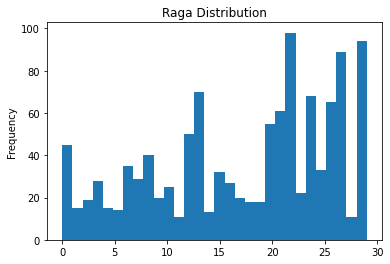

In [13]:
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [14]:
data['Offset'].fillna(60,inplace=True)

# Common functions that are needed for rest of notebook

In [15]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [16]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight('balanced',
                                         np.unique(labels),
                                         labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [17]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [18]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions):
    s = 'micro'
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [19]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, txt, hidden: model(data, txt, hidden) if hidden else model(data, txt)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      print('Training Model')
      model.train()
  else:
      print('Evaluating Model')
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, txt_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, txt_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, txt_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [20]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [21]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [22]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data['RagamCode']
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[['mfcc_mean']], data['RagamCode'])):
    print(f'FOLD {fold} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data['RagamCode'].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        print('Epoch {:} / {:}'.format(epoch + 1, epochs))
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        print(f'Losses - Train : {train_loss:.3f} / Validation : {valid_loss:.3f}')
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Time for epoch : {(e_end - e_start).total_seconds()} seconds')
    print('On Train Data')
    print(classification_report(best_scores['train_labels'], best_scores['train_predictions']))
    print('On Test Data')
    print(classification_report(best_scores['test_labels'], best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Time for fold {fold} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(train_predictions,train_labels))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(test_predictions,test_labels))
  if plot:
    plot_results(results, title)
  return results

In [23]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# Experiment 1 - Using Mean levels of MFCC Values and FT Vectors (300 elem)
40 MFCC Values are precomputed using MATLAB
## Experiment 1.1 - Feed forward model

In [24]:
class MfccDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals, ft_vectors):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals
        self.ft_vectors = ft_vectors

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.mfcc_vals[index][1:], self.ft_vectors[index], self.labels[index]

    def __getitem__(self, index):
        return self.mfcc_vals[index][1:], self.ft_vectors[index], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in train_ids])
      test_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in test_ids])
      train_ft = torch.tensor([[_ for _ in data['ft_vector'].iloc[x]] for x in train_ids])
      test_ft = torch.tensor([[_ for _ in data['ft_vector'].iloc[x]] for x in test_ids])
      train_data = MfccDataset(train_lbls, train_vals, train_ft)
      test_data = MfccDataset(test_lbls, test_vals, test_ft)
      return train_data, test_data, train_lbls, test_lbls

In [25]:
class MfccFtVecRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.n_labels = n_labels
        self.mfcc = nn.Sequential(
            nn.Linear(40, 80), nn.GELU(),
            nn.Linear(80, 160), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(160, 320), nn.GELU(), nn.Dropout(dropout)
        )
        self.ft = nn.Sequential(
            nn.Linear(300, 600), nn.GELU(),
            nn.Linear(600, 1200), nn.GELU(), nn.Dropout(dropout)
        )
        self.final = nn.Linear(320 + 1200, self.n_labels)
    def forward(self, x, t):
        x = self.mfcc(x)
        t = self.ft(t)
        x = torch.cat((x,t),dim=1)
        return self.final(x)

FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.516 / Validation : 3.427
Time for epoch : 0.283298 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.422 / Validation : 3.449
Time for epoch : 0.194462 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.319 / Validation : 3.463
Time for epoch : 0.191475 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.229 / Validation : 3.572
Time for epoch : 0.191562 seconds
Epoch 5 / 10

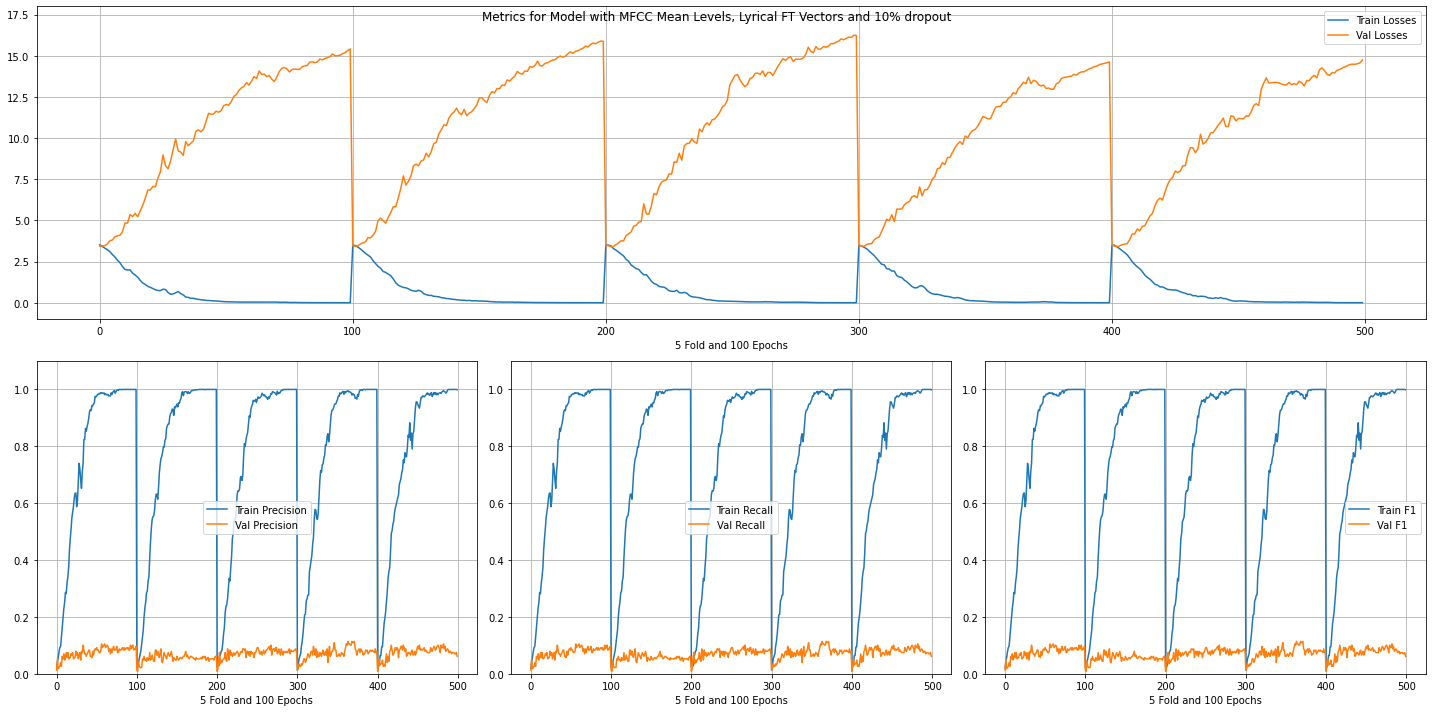

In [26]:
mfcc_ft_fusion_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Mean Levels, Lyrical FT Vectors and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

In [27]:
print('*** Results for Model with MFCC Mean Levels and 10% dropout ***')
mfcc_ft_fusion_results_df = results_to_df(mfcc_ft_fusion_results)
mfcc_ft_fusion_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
63,0.995614,0.114035,0.995614,0.114035,0.995614,0.114035,0.027088,13.011783
71,0.981360,0.114035,0.981360,0.114035,0.981360,0.114035,0.040375,13.251601
68,0.980263,0.114035,0.980263,0.114035,0.980263,0.114035,0.041719,13.307655
69,0.985746,0.109649,0.985746,0.109649,0.985746,0.109649,0.038368,13.514695
70,0.981360,0.109649,0.981360,0.109649,0.981360,0.109649,0.045034,13.452171
...,...,...,...,...,...,...,...,...
0,0.020833,0.013158,0.020833,0.013158,0.020833,0.013158,3.515753,3.427063
0,0.013158,0.013158,0.013158,0.013158,0.013158,0.013158,3.508091,3.457305
1,0.025219,0.008772,0.025219,0.008772,0.025219,0.008772,3.472562,3.422880
0,0.024123,0.008772,0.024123,0.008772,0.024123,0.008772,3.511446,3.454422


# Experiment 2 - MFCC Matrix Fusion with FT Vectors

In [28]:
FREQ = 16000
DURATION = 120
mfcc_tx = transforms.MFCC(FREQ, n_mfcc=40)
def get_mfcc(x, aud_path, mfcc_tx):
  aud_path = os.path.join(aud_path, x['MP3 File'])
  i = torchaudio.info(aud_path)
  waveform, sample_rate = torchaudio.load(aud_path, 
                                          frame_offset=int(x['Offset']*i.sample_rate), 
                                          num_frames= DURATION*i.sample_rate)
  waveform = librosa.to_mono(waveform)
  resampler = transforms.Resample(sample_rate, FREQ)
  if len(waveform) > 0 :
    waveform = resampler(torch.tensor(waveform))
    mfcc = mfcc_tx(waveform)
  else:
    mfcc = []
  return mfcc
data['mfcc'] = data.apply(lambda x:get_mfcc(x, AUD_PATH, mfcc_tx),axis=1)
# Remove samples where MFCC returned empty
data = data[data.apply(lambda x:not isinstance(x['mfcc'],list),axis=1)]

In [29]:
class MfccFtMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals, ft_vectors):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals
        self.ft_vectors = ft_vectors

    def __get__(self,index):
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.ft_vectors[index], self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.ft_vectors[index], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_ft = torch.tensor([[_ for _ in data['ft_vector'].iloc[x]] for x in train_ids])
      test_ft = torch.tensor([[_ for _ in data['ft_vector'].iloc[x]] for x in test_ids])
      train_data = MfccFtMatrixDataset(train_lbls, train_vals, train_ft)
      test_data = MfccFtMatrixDataset(test_lbls, test_vals, test_ft)
      return train_data, test_data, train_lbls, test_lbls

In [30]:
class MfccFtRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MFCC Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.layers2 = nn.Sequential(
            nn.Linear(300, 600), nn.ReLU(),
            nn.Linear(600, 1200), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(1200, 2400), nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.Linear(384000+2400,n_labels)
        )
        
    def forward(self,x,t):
        x = self.layers1(x)
        t = self.layers2(t)
        x = torch.cat((x,t),dim=1)
        x = self.final(x)
        return x

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 482.365 / Validation : 3.404
Time for epoch : 4.237586 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.401 / Validation : 3.404
Time for epoch : 4.021805 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.401 / Validation : 3.403
Time for epoch : 4.139543 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.399 / Validation : 3.403
Time for epoch : 4.149703 seconds
Epoch 5

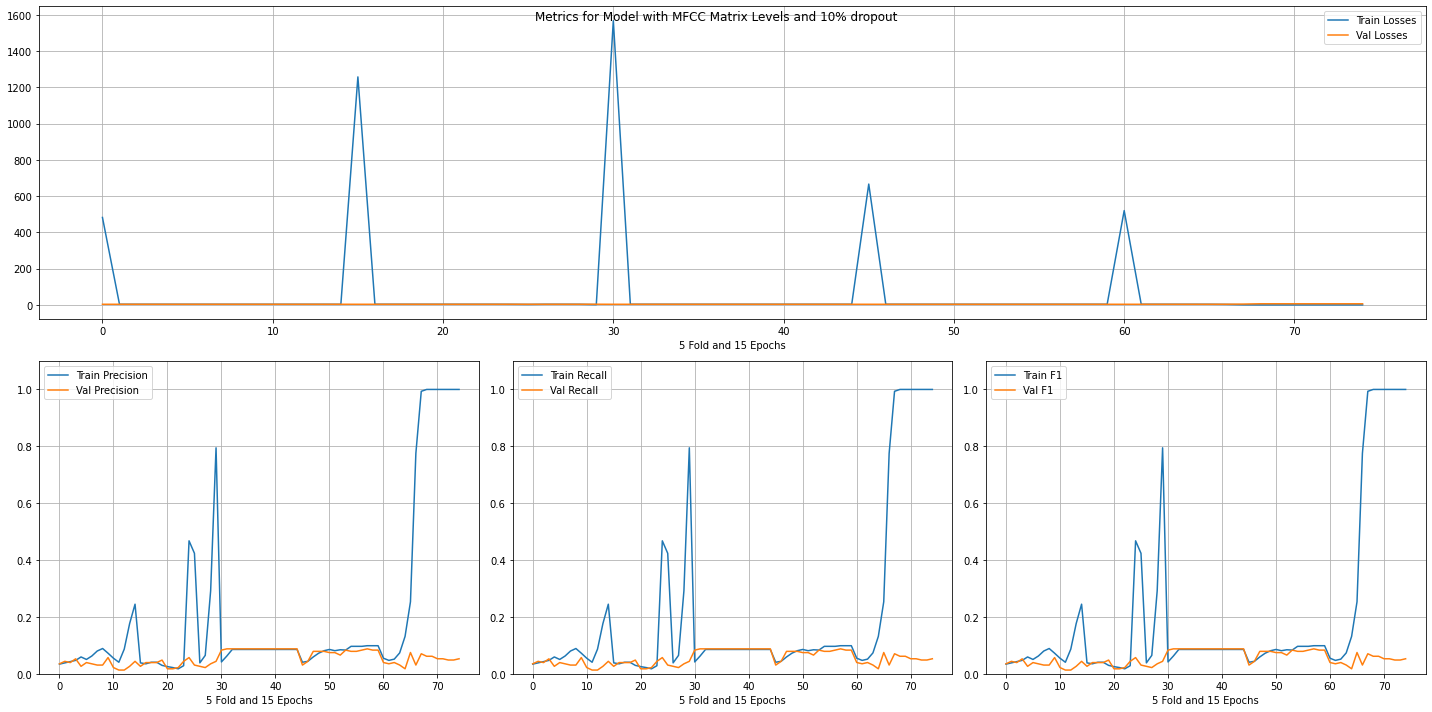

In [31]:
mfcc_ft_matrix_results = train_model(data, MfccFtMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Matrix Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccFtRaga})

In [32]:
print('*** Results for Model with MFCC Mean Levels and FT Vector Fusion and 10% dropout ***')
mfcc_ft_matrix_results_df = results_to_df(mfcc_ft_matrix_results)
mfcc_ft_matrix_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and FT Vector Fusion and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
12,0.098793,0.087719,0.098793,0.087719,0.098793,0.087719,3.395382,3.403254
7,0.085620,0.087719,0.085620,0.087719,0.085620,0.087719,3.401937,3.401223
6,0.085620,0.087719,0.085620,0.087719,0.085620,0.087719,3.401964,3.401288
4,0.085620,0.087719,0.085620,0.087719,0.085620,0.087719,3.402011,3.401433
3,0.085620,0.087719,0.085620,0.087719,0.085620,0.087719,3.402042,3.401515
...,...,...,...,...,...,...,...,...
4,0.131579,0.017621,0.131579,0.017621,0.131579,0.017621,3.380805,3.404894
5,0.025247,0.017544,0.025247,0.017544,0.025247,0.017544,3.401168,3.401900
6,0.021954,0.017544,0.021954,0.017544,0.021954,0.017544,3.401038,3.401915
12,0.086718,0.013158,0.086718,0.013158,0.086718,0.013158,3.335399,3.416276


## Experiment 2.1 MFCC LSTM FT Vector Fusion

In [36]:
class MfccFtLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=2):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.ft = nn.Sequential(nn.Linear(300, 600), nn.GELU(),
                                nn.Linear(600,1200), nn.GELU(), nn.Dropout(dropout))
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim + 1200,160),
                                nn.GELU(),
                                nn.Linear(160,self.n_labels))

    def forward(self,x,t,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        t = self.ft(t)
        x = torch.cat((x,t),dim=1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

FOLD 0 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.8437037  2.53111111 1.99824561 1.35595238 2.53111111 2.71190476
 1.0847619  1.3091954  0.94916667 1.89833333 1.51866667 3.45151515
 0.77482993 0.54238095 2.92051282 1.18645833 1.40617284 1.89833333
 2.10925926 2.10925926 0.69030303 0.62240437 0.38741497 1.72575758
 0.55833333 1.15050505 0.58410256 0.42659176 3.45151515 0.40390071]
Epoch 1 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.451 / Validation : 3.419
Time for epoch : 52.397521 seconds
Epoch 2 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.401 / Validation : 3.431
Time for epoch : 52.734793 seconds
Epoch 3 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.267 / Validation : 3.485
Time for epoch : 52.429168 seconds
Epoch 4 / 15
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.076 / Validation : 3.689
Time for epoch : 52.347897 seconds
Epoch

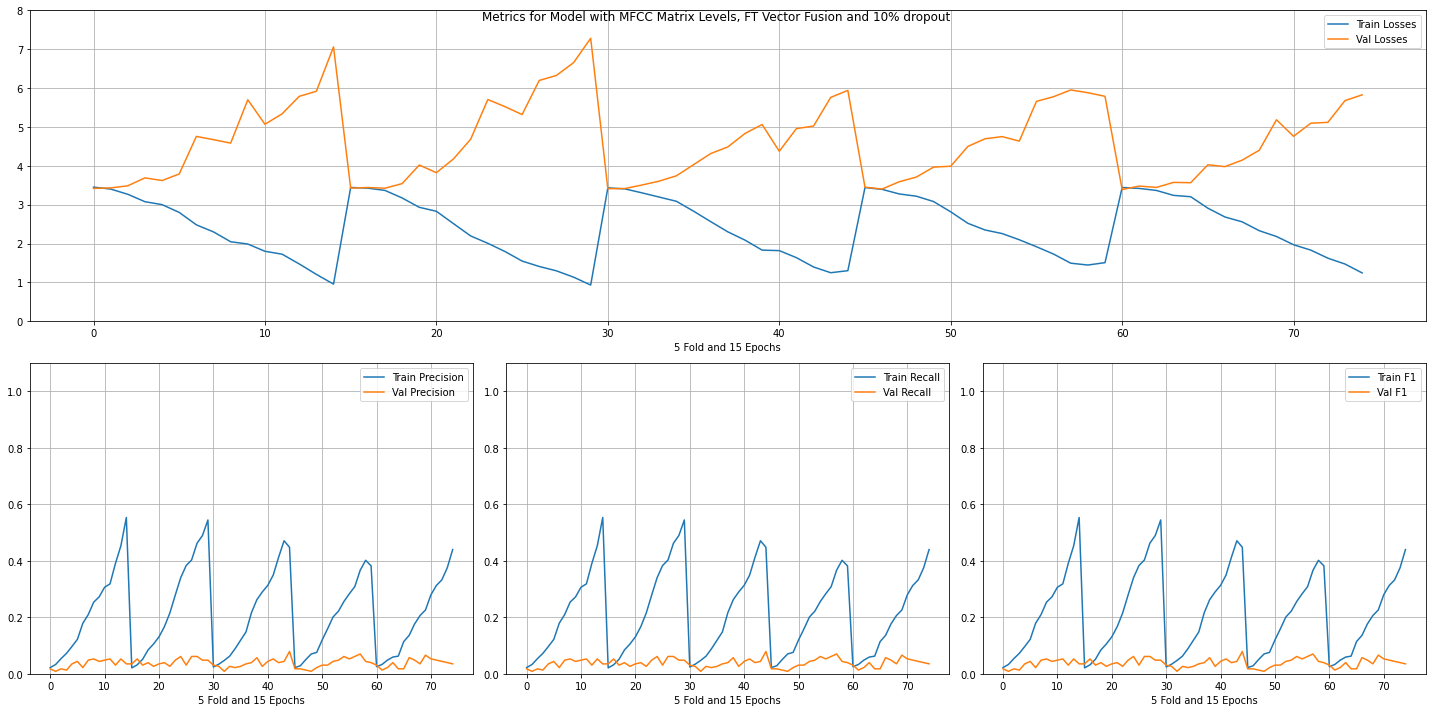

In [37]:
mfcc_matrix_ft_bidir_lstm_results = train_model(data, MfccFtMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Matrix Levels, FT Vector Fusion and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccFtLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})

In [38]:
print('*** Results for Model with MFCC Mean Levels and FT Vector Fusion and 10% dropout ***')
mfcc_matrix_ft_bidir_lstm_results_df = results_to_df(mfcc_matrix_ft_bidir_lstm_results)
mfcc_matrix_ft_bidir_lstm_results_df.sort_values(by=['validation_f1', 'train_f1'], ascending=False)

*** Results for Model with MFCC Mean Levels and FT Vector Fusion and 10% dropout ***


,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall,train_losses,validation_losses
14,0.447859,0.078947,0.447859,0.078947,0.447859,0.078947,1.300424,5.940497
12,0.366630,0.070175,0.366630,0.070175,0.366630,0.070175,1.493349,5.951990
9,0.225877,0.066079,0.225877,0.066079,0.225877,0.066079,2.180508,5.184199
12,0.462130,0.061404,0.462130,0.061404,0.462130,0.061404,1.296414,6.325498
11,0.402854,0.061404,0.402854,0.061404,0.402854,0.061404,1.408570,6.196829
...,...,...,...,...,...,...,...,...
3,0.072448,0.013158,0.072448,0.013158,0.072448,0.013158,3.075867,3.689383
2,0.050494,0.013158,0.050494,0.013158,0.050494,0.013158,3.275147,3.589648
3,0.070252,0.008772,0.070252,0.008772,0.070252,0.008772,3.217220,3.711061
2,0.047201,0.008772,0.047201,0.008772,0.047201,0.008772,3.302738,3.506217
